# predicting health coverage in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import utils
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,roc_auc_score, auc, f1_score, precision_recall_curve

To predict which kind of insurance (if any) an individual has based on other attributes available in the census record, we can use supervised learning algorithms. Below we will try and compare logistic regression, SVM, and a random forest model.

In [2]:
# load pre-processed/scaled training data:
X_train  = pd.read_pickle('X_scaled_train.pkl')
y_train  = pd.read_pickle('y_train.pkl')

X_test  = pd.read_pickle('X_scaled_test.pkl')
y_test  = pd.read_pickle('y_test.pkl')

In [3]:
nsamples = 500
datadir  = os.path.join(os.getcwd(),"data")

fname = os.path.join(datadir,str(nsamples) + 'targets_oi.csv')
targ_oi  = pd.read_csv(fname)
targname = targ_oi['healthcodes'][1]

details = utils.variableDetails(targname)
targlabels = details['values']['item'].values()

First, let's try logistic regression. We have many numerical variables though. Maybe we can use PCA to reduce dimensions on the numeric variables?

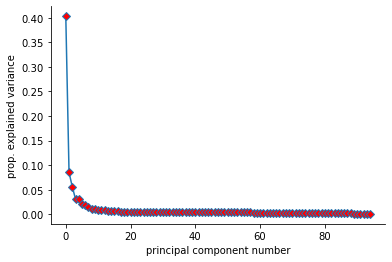

In [4]:
from sklearn.decomposition import PCA

num_train = X_train.select_dtypes('float')
num_test  = X_test.select_dtypes('float')

pc   = PCA().fit(num_train)

pc_train = pc.transform(num_train)
pc_test  = pc.transform(num_test)


plt.plot(pc.explained_variance_ratio_,marker='D',mfc='red')
sns.despine()
plt.ylabel('prop. explained variance')
plt.xlabel('principal component number')
plt.show()

In [5]:
# piece together categorical vars + first two principal components (from numerical columns)
pc_Xtrain = X_train.select_dtypes('uint8')
pc_Xtrain['pc_1'] = pc_train[:,0]
pc_Xtrain['pc_2'] = pc_train[:,1]

pc_Xtest= X_test.select_dtypes('uint8')
pc_Xtest['pc_1'] = pc_test[:,0]
pc_Xtest['pc_2'] = pc_test[:,1]

logistic regression results:
overall accuracy: 0.7379084967320262


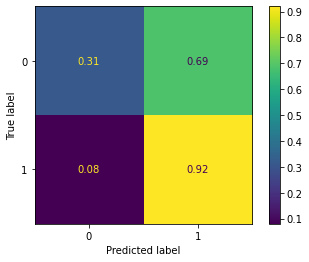

In [6]:
# logistic regression 
from sklearn.linear_model import LogisticRegression

Cs= [0.01, 0.1, 1, 10, 100]
params = {'C':Cs}
logreg = LogisticRegression(solver='liblinear') 
lr_cv  = GridSearchCV(logreg,params,cv=KFold(5))
lr_cv.fit(pc_Xtrain,y_train)

y_pred=lr_cv.predict(pc_Xtest)
ac = accuracy_score(y_test, y_pred)
print('logistic regression results:')
print('overall accuracy: ' + str(ac))
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,normalize='true')

random forest model results:
overall accuracy: 0.7551633986928105


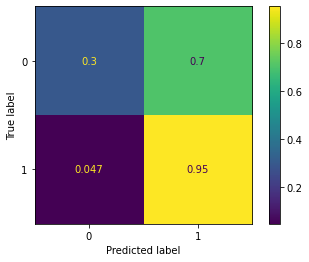

In [7]:
# random forest model
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators':[10,100,300,500,1000]}
rf_mdl = RandomForestClassifier()
rf_cv  = GridSearchCV(estimator=rf_mdl,param_grid=params,cv=KFold(5))
rf_cv.fit(X_train,y_train)
y_pred = rf_cv.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print('random forest model results:')

print('overall accuracy: ' + str(ac))
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,normalize='true')